In [1]:
!pip install pyspark
!pip install geopandas
!pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=01ceb9e3db5908363d3d556da223fdae313c5fbf92e5e85f3afdad2527236dce
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName('DB_Final_Project').getOrCreate()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
taxi= spark.read\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .parquet("/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-01.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-02.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-03.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-04.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-05.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-06.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-07.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-08.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-09.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-10.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-11.parquet",
          "/content/drive/MyDrive/yellow_tripdata_2022/yellow_tripdata_2022-12.parquet")

In [5]:
taxi=taxi.na.drop(how="any")

In [6]:
taxi=taxi.filter(year(col("tpep_pickup_datetime"))=="2022")

In [7]:
taxi=taxi.distinct()

In [8]:
date="2022-"+input("What month do you want to know? enter in type mm: ")
pickup_by_month=taxi.filter(col("tpep_pickup_datetime").startswith(date))

What month do you want to know? enter in type mm: 06


In [9]:
pbm_hour=pickup_by_month.select(hour(col("tpep_pickup_datetime")).alias("hour")).groupby("hour").count()

In [10]:
#pbm_hour.show(5)

+----+------+
|hour| count|
+----+------+
|  12|190637|
|  22|169755|
|   1| 63400|
|  13|192780|
|   6| 53811|
+----+------+
only showing top 5 rows



In [11]:
pbm_hour_pd=pbm_hour.sort("hour").toPandas()

Most pickup hour:  18, having 241688  pickup counts.
Least pickup hour:  4, having  18026  pickup counts.


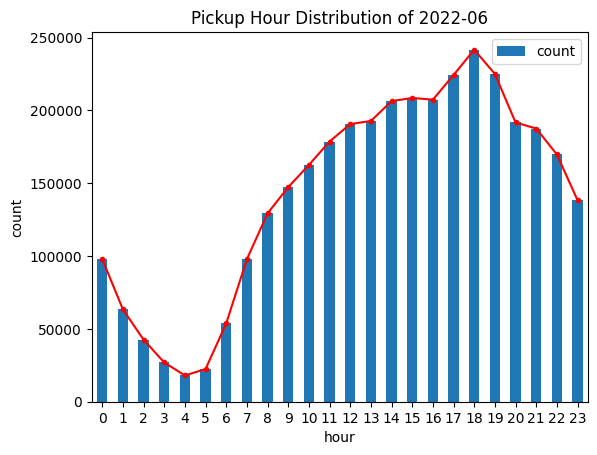

In [18]:
print("Most pickup hour: {:3d}, having {:6d}  pickup counts."
    .format(pbm_hour_pd['hour'].loc[pbm_hour_pd['count'].idxmax()],pbm_hour_pd["count"].max()))
print("Least pickup hour: {:2d}, having {:6d}  pickup counts."
    .format(pbm_hour_pd['hour'].loc[pbm_hour_pd['count'].idxmin()],pbm_hour_pd["count"].min()))
#pbm_hour_pd=pbm_hour_pd
pbm_hour_pd.plot.bar(x='hour', y='count')
plt.plot(pbm_hour_pd["hour"],pbm_hour_pd["count"],color="r",marker=".")
plt.title(f"Pickup Hour Distribution of {date}")
plt.xlabel("hour")
plt.ylabel("count")
plt.xticks(rotation=0)
plt.show()

In [13]:
import geopandas as gpd
shapefile_path = "/content/drive/MyDrive/yellow_tripdata_2022/taxi_zones.zip"

gdf = gpd.read_file(shapefile_path)


In [14]:
pbm_location=pickup_by_month.select(col("PULocationID").alias("LocationID")).groupBy("LocationID").count()

In [15]:
pbm_location_pd=pbm_location.toPandas()

In [16]:
gdf_location = gdf.merge(pbm_location_pd, on='LocationID', suffixes=('', '_count'),how="left")
gdf_location['count'] = gdf_location['count'].fillna(0)

Most pickup zone:  JFK Airport  in  Queens  borough, having 169324.0  pickup location.


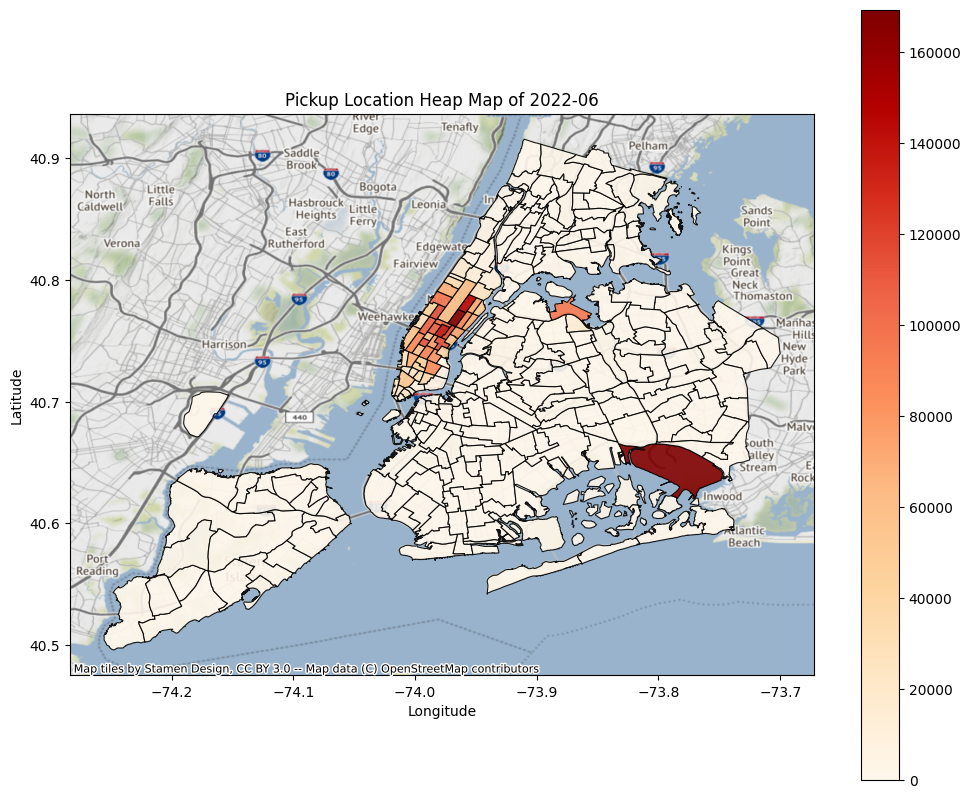

In [35]:
print("Most pickup zone: ",gdf_location['zone'].loc[gdf_location['count'].idxmax()],
      " in ",gdf_location['borough'].loc[gdf_location['count'].idxmax()],
      f" borough, having {gdf_location['count'].max()}  pickup location.")
import contextily as cx
fig, ax = plt.subplots(figsize=(12, 10))
#plot heap map of pickups
gdf_location=gdf_location.to_crs(epsg=4326)
gdf_location.plot(column='count', cmap='OrRd', linewidth=0.8,
        ax=ax, edgecolor='k', alpha=0.9,legend=True)
#add NYC borough as basemap
cx.add_basemap(ax,crs=gdf_location.crs)
ax.set_title(f'Pickup Location Heap Map of {date}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Most dropoff zone:  Upper East Side North  in  Manhattan  borough, having 145998.0  dropoff location.


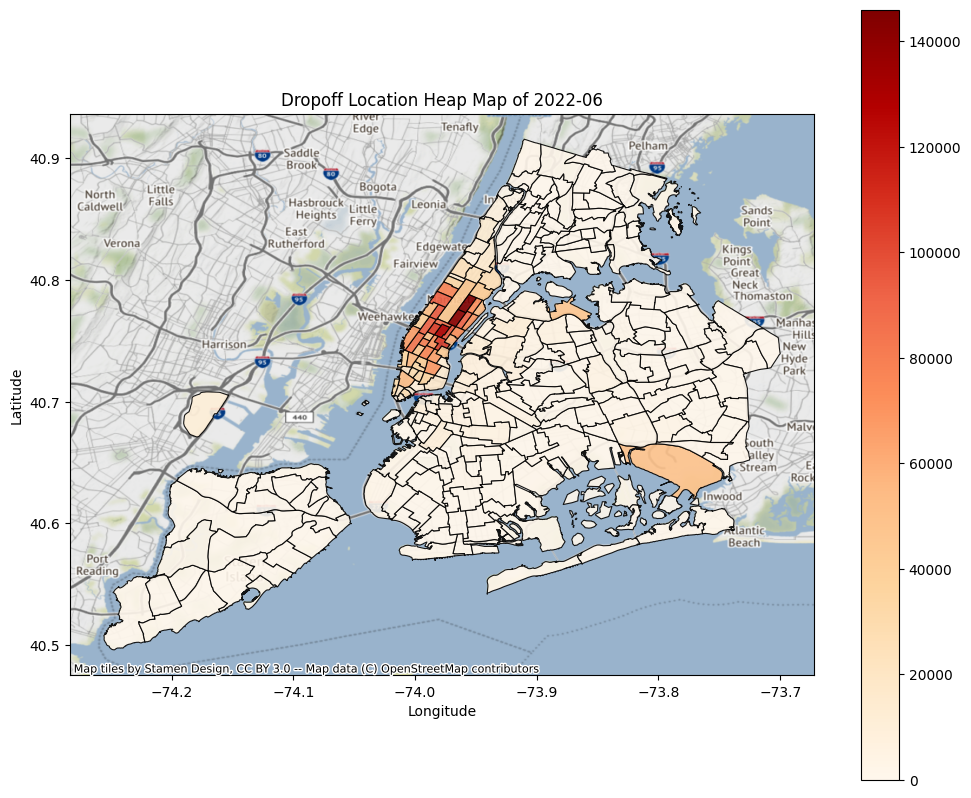

In [36]:
pbm_dolocation=pickup_by_month.select(col("DOLocationID").alias("LocationID")).groupBy("LocationID").count()
pbm_dolocation_pd=pbm_dolocation.toPandas()
gdf_dolocation = gdf.merge(pbm_dolocation_pd, on='LocationID', suffixes=('', '_count'),how="left")
gdf_dolocation['count'] = gdf_dolocation['count'].fillna(0)
print("Most dropoff zone: ",gdf_dolocation['zone'].loc[gdf_dolocation['count'].idxmax()],
      " in ",gdf_dolocation['borough'].loc[gdf_dolocation['count'].idxmax()],
      f" borough, having {gdf_dolocation['count'].max()}  dropoff location.")
gdf_dolocation=gdf_dolocation.to_crs(epsg=4326)
fig, ax = plt.subplots(figsize=(12, 10))
gdf_dolocation.plot(column='count', cmap='OrRd', linewidth=0.8,
        ax=ax, edgecolor='k', alpha=0.9,legend=True)

cx.add_basemap(ax,crs=gdf_dolocation.crs)
ax.set_title(f'Dropoff Location Heap Map of {date}')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()